In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 58.6 MB/s eta 0:00:00


In [2]:
# First, check if GPU is available
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 784  # 28x28 pixels
num_epochs = 100
batch_size = 128  # Increased for GPU
lr = 0.0002

Using device: cuda


In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


In [12]:
# Initialize networks and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Lists to store losses for plotting
g_losses = []
d_losses = []

In [14]:
def train_gan():
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.view(-1, image_dim).to(device)

            # Labels for real and fake images
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

                # Generate and display images every 100 steps
                if (i + 1) % 500 == 0:
                    generate_images(4)  # Generate fewer images during training
                    plt.show()

def generate_images(num_images=16):
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = generator(z)
        generated_images = generated_images.cpu().view(-1, 28, 28)

        # Plot the generated images
        fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)),
                                figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            if i < num_images:
                ax.imshow(generated_images[i], cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        display.clear_output(wait=True)
        plt.show()
    generator.train()  # Set back to training mode

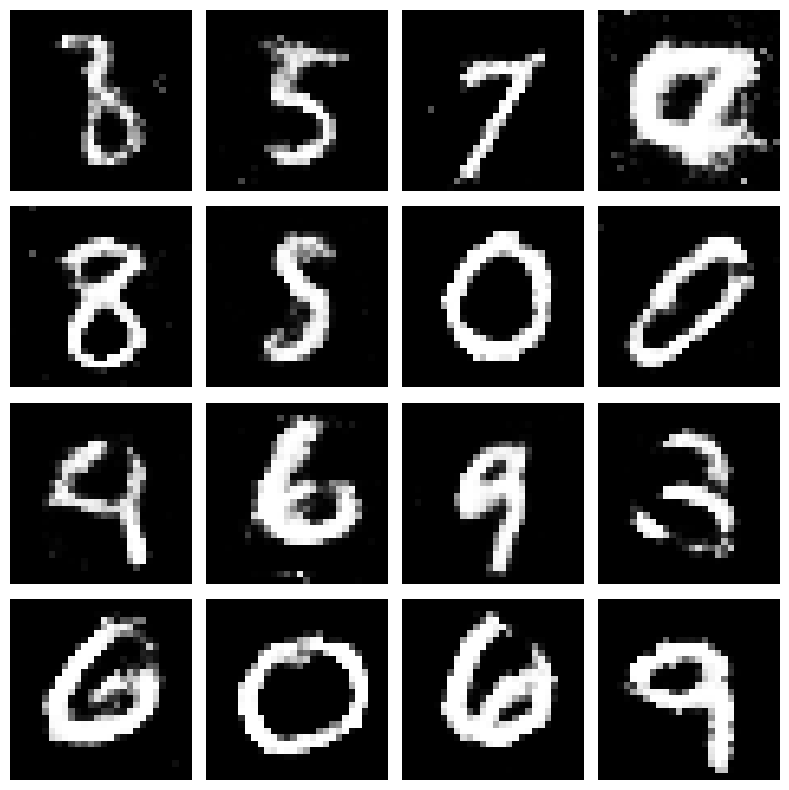

In [15]:
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()

# Training code
if __name__ == "__main__":
    train_gan()
    plot_losses()
    generate_images(16)

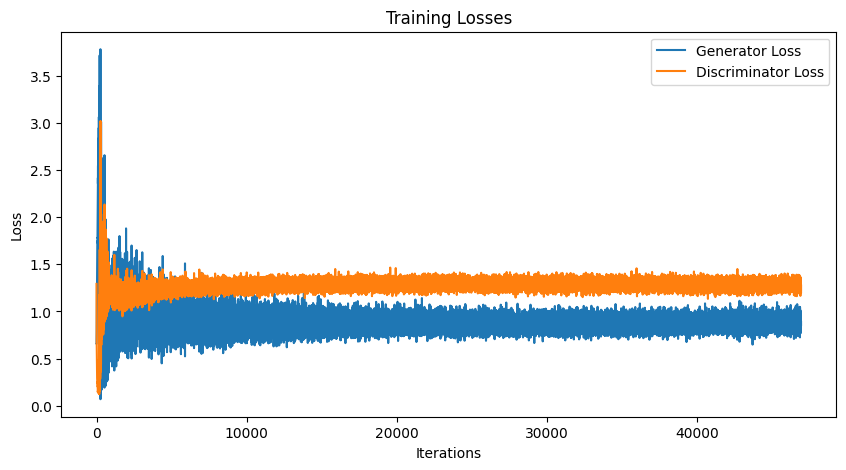

In [16]:
plot_losses()